In [1]:
! pip3 install torch==1.7.1
! git clone https://github.com/arpytanshu/multivar_tsfc.git

     |████████████████████████████████| 776.8 MB 17 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
Cloning into 'multivar_tsfc'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 41 (delta 0), reused 41 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.


# New Section

In [2]:

import os
import sys
import pandas as pd
from glob import glob
from time import time
from copy import deepcopy
import matplotlib.pyplot as plt
import json
import torch
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.utils.data as torch_data


sys.path.append('/content/multivar_tsfc/')


from multivar.stemGNN.forecast_dataloader import ForecastDataset, align_df
from multivar.stemGNN.config import config
from multivar.stemGNN.handler import train

from multivar.stemGNN.base_model import Model
from multivar.stemGNN.eval_utils import evaluate
from multivar.stemGNN.forecast_dataloader import ForecastDataset, de_normalized


config.window_size = 128
config.horizon = 8
config.num_series_in_data = 18
config.num_target_series = 18
config.validate_freq = 1

config.batch_size = 128
config.epoch = 20
config.device = 'cuda'
config.use_backcast_loss = False

CHECKPOINT_BASE_PATH = '/content/output/'

In [4]:
data_file = '/content/ene_df_wo_fc.csv'

df = pd.read_csv(data_file)
df = align_df(df, config)
data = df.values

# create checkpoint directories
# ------ ---------- -----------
result_file = os.path.join(CHECKPOINT_BASE_PATH, 'stemGNN', config.dataset, 'train')
result_test_file = os.path.join(CHECKPOINT_BASE_PATH, 'stemGNN', config.dataset, 'test')
if not os.path.exists(result_file): os.makedirs(result_file)
if not os.path.exists(result_test_file): os.makedirs(result_test_file)

# create train and valid datasets
# ------ ----- --- ----- --------
train_ratio = config.train_length / (config.train_length + config.valid_length + config.test_length)
valid_ratio = config.valid_length / (config.train_length + config.valid_length + config.test_length)
train_data = data[:int(train_ratio * len(data))]
valid_data = data[int(train_ratio * len(data)):int((train_ratio + valid_ratio) * len(data))]



In [5]:
stats = train(train_data, valid_data, config, result_file)

Total Trainable Params: 119806820


/content/multivar_tsfc/multivar/stemGNN/base_model.py:50: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  ffted = torch.rfft(input, 1, onesided=False)
/content/multivar_tsfc/multivar/stemGNN/base_model.py:59: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  iffted = torch.irfft(time_step_as_inner, 1, onesided=False)


||

KeyboardInterrupt: ignored

In [ ]:

with open('/content/output/stemGNN/checkpoint/train/norm_stat.json', 'r') as f:
    normalize_statistic = json.load(f)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

args = config
node_cnt = train_data.shape[1]
valid_set = ForecastDataset(valid_data, window_size=config.window_size, horizon=config.horizon,
                            normalize_method=config.norm_method, norm_statistic=normalize_statistic)
valid_loader = torch_data.DataLoader(valid_set, batch_size=1, shuffle=False, num_workers=0)


model = torch.load('/content/output/stemGNN/checkpoint/train/8_stemgnn.pt', map_location=torch.device('cuda'))
device = torch.device('cuda')
horizon = args.horizon
window_size = args.window_size

attentions = []
forecast_set = []
target_set = []
input_set = []
backcast_set = []

model.eval()
with torch.no_grad():
    for i, (inputs, target) in enumerate(valid_loader):
        if i%100==0: print('.', end='')
        inputs = inputs.to(device)
        target = target.to(device)
        input_set.append(inputs.detach().cpu().numpy())
        forecast_steps = np.zeros([inputs.size()[0], horizon, node_cnt], dtype=np.float)
        
        step = 0
        while step < horizon:
            forecast_result, attention, backcast_result = model(inputs)
            len_model_output = forecast_result.size()[1]
            if len_model_output == 0:
                raise Exception('Get blank inference result')
            inputs[:, :window_size - len_model_output, :] = inputs[:, len_model_output:window_size,
                                                               :].clone()
            inputs[:, window_size - len_model_output:, :] = forecast_result.clone()
            forecast_steps[:, step:min(horizon - step, len_model_output) + step, :] = \
                forecast_result[:, :min(horizon - step, len_model_output), :].detach().cpu().numpy()
            step += min(horizon - step, len_model_output)


            attentions.append(attention.detach().cpu().numpy())    
            forecast_set.append(forecast_steps)
            target_set.append(target.detach().cpu().numpy())
            backcast_set.append(backcast_result.squeeze(1).permute(0,2,1).detach().cpu().numpy())

        

forecast_set = np.vstack(forecast_set) # R[timestamps, horizon, nodes]
print(forecast_set.shape)

target_set = np.vstack(target_set) # R[timestamps, horizon, nodes]
print(target_set.shape)

backcast_set = np.vstack(backcast_set) # R[timestamps, backcast_len, nodes]
print(abckcast_set.shape)

input_set = np.vstack(input_set) # R[timestamps, backcast_len, nodes]
print(input_set.shape)

attentions = np.array(attentions)  # R[timestamps, nodes, nodes]
print(attentions.shape)


(6878, 8, 18)
(6878, 8, 18)
(6878, 128, 18)
(6878, 128, 18)
(6878, 18, 18)


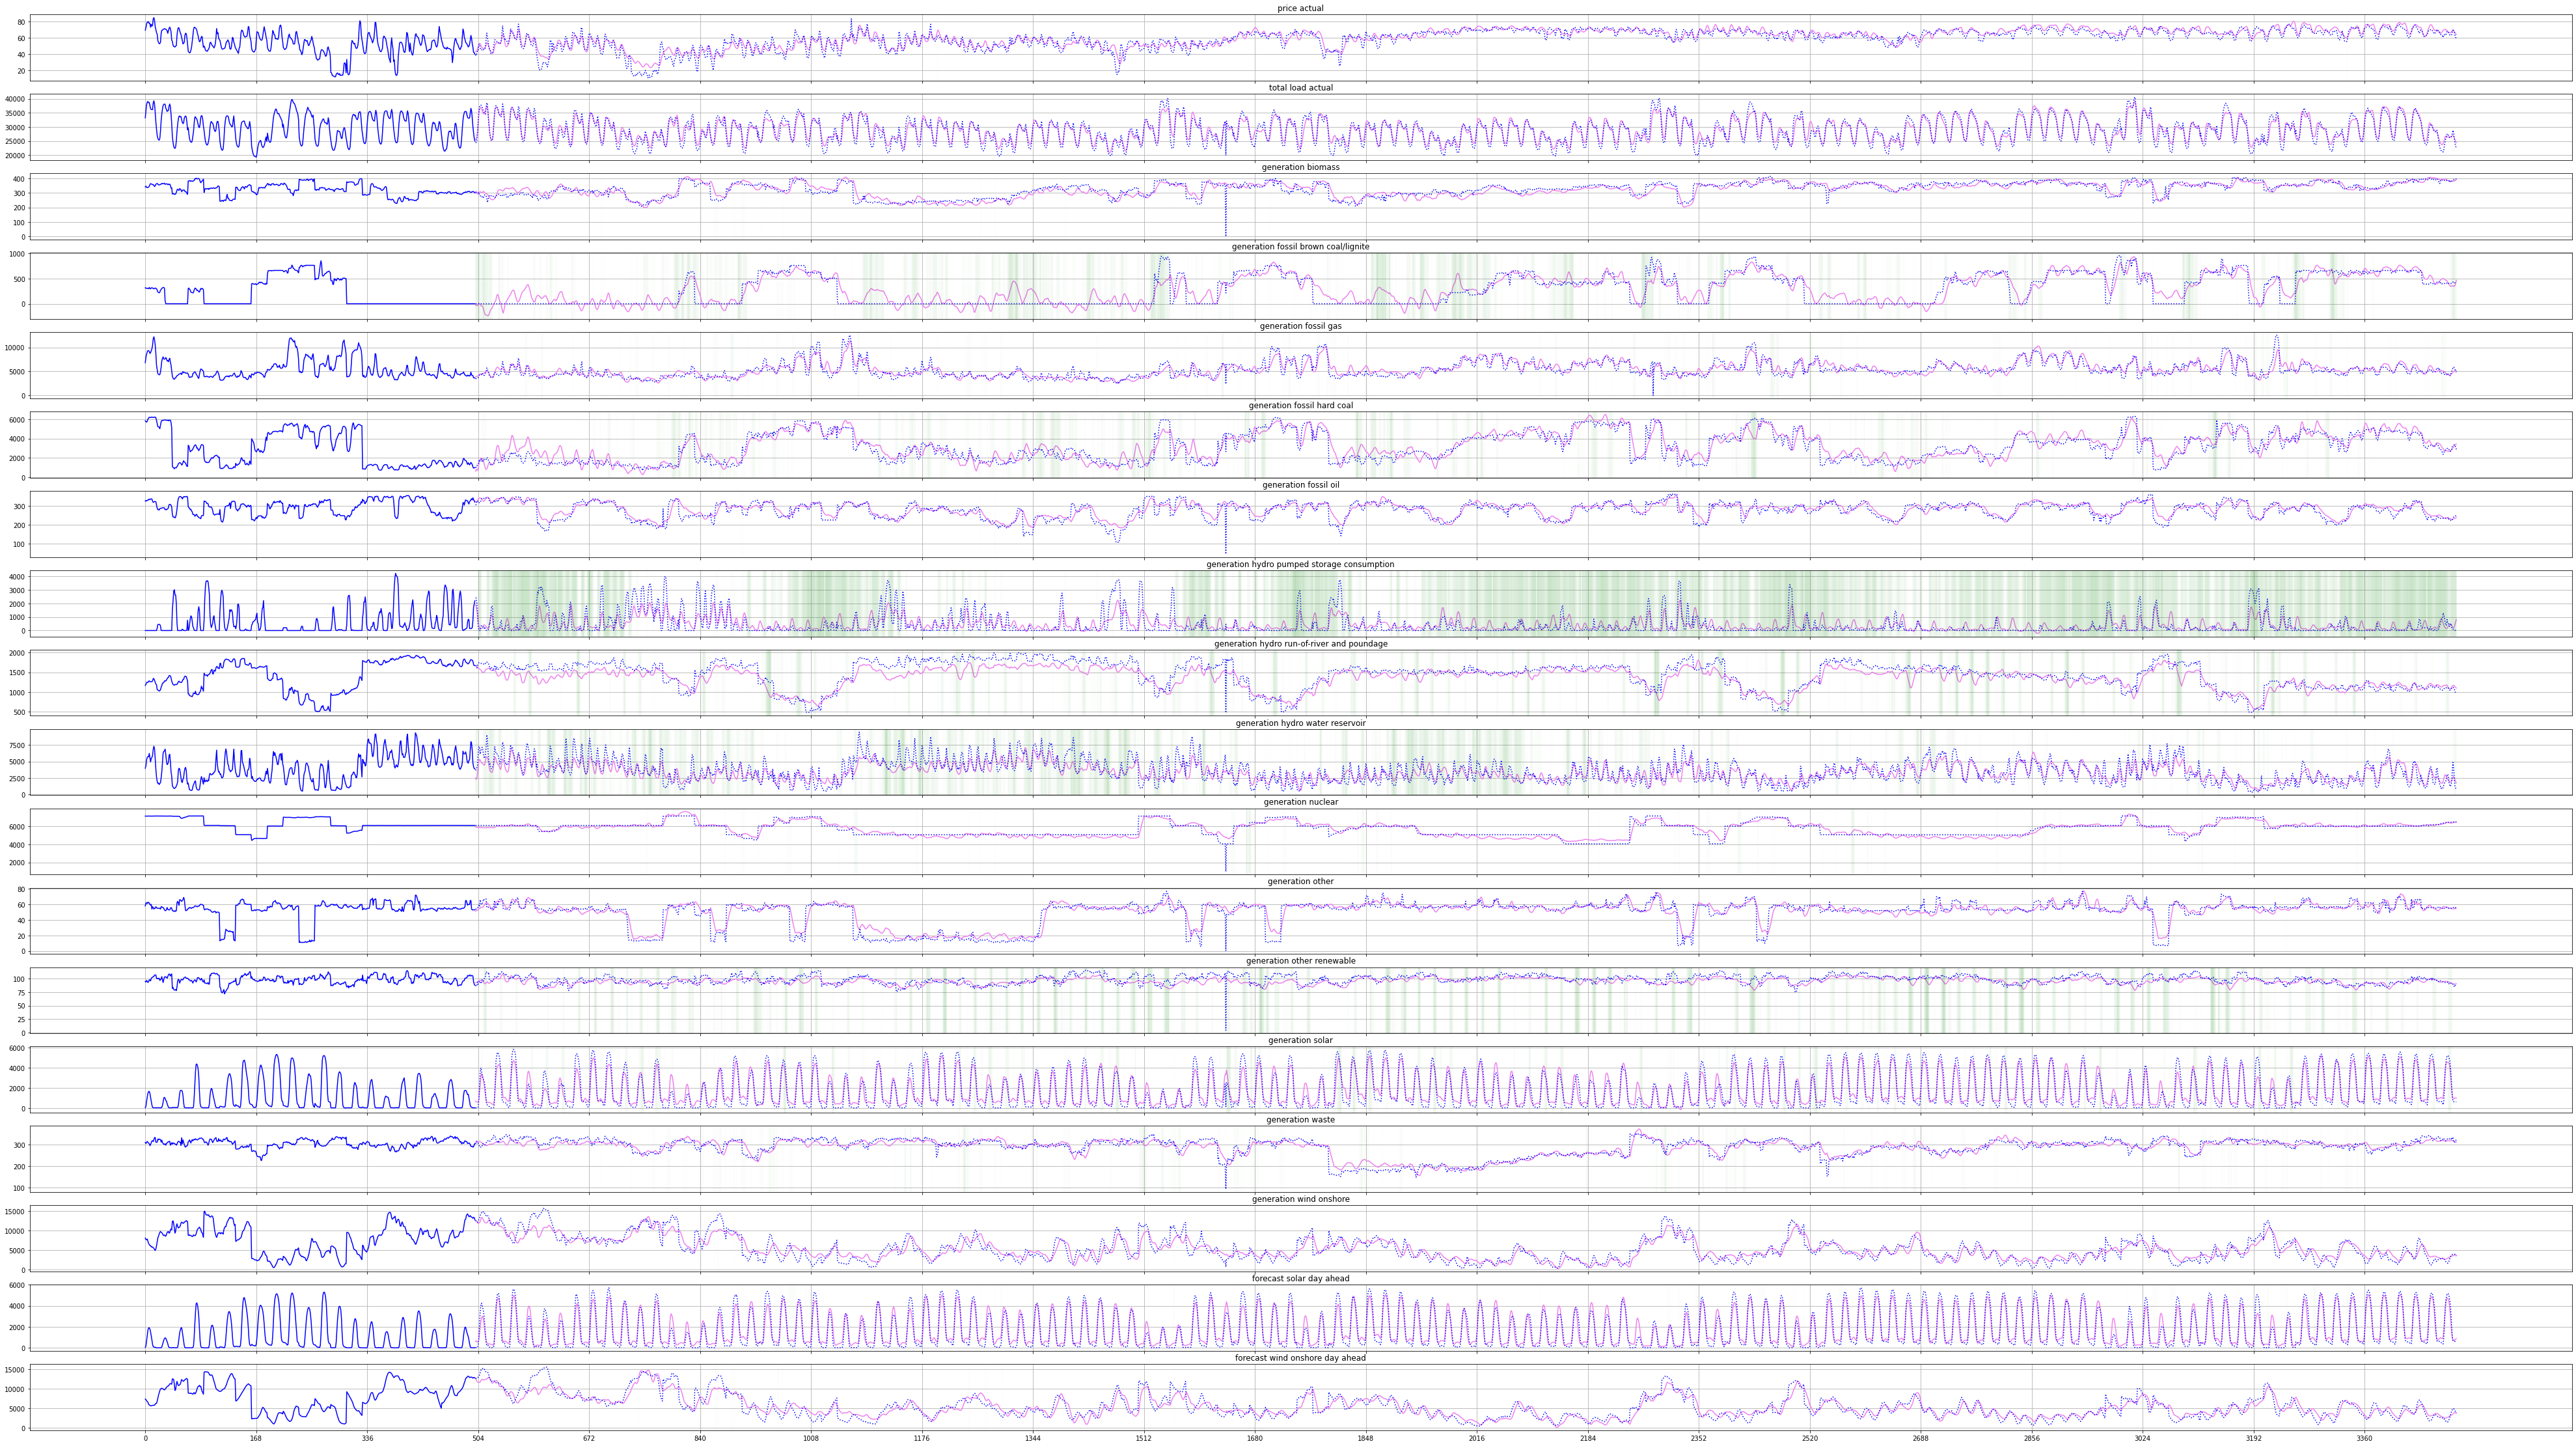

In [ ]:
def syncer(x):
    win_len = x.shape[1]
    num_win = x.shape[0]
    # synced = np.stack([np.diag(x[:,::-1],ix) for ix in range(win_len-num_win, 1)])
    means = np.array([np.diag(x[:,::-1],ix).mean() for ix in list(range(win_len-1, -num_win, -1))])
    stds = np.array([np.diag(x[:,::-1],ix).std() for ix in list(range(win_len-1, -num_win, -1))])
    return means, stds


hist_len = 500
forecast_len = 3000
model_window_length = 128


FIRST_FORECAST_IX = 28051+128

num_fc_window = forecast_set.shape[0]
window_length = forecast_set.shape[1]
num_nodes = forecast_set.shape[2]

# denormalize forecasts and targets
forecast_set_denormed = ((forecast_set * normalize_statistic['std']) + normalize_statistic['mean'])
target_set_denormed = ((target_set * normalize_statistic['std']) + normalize_statistic['mean'])
backcast_set_denormed = ((backcast_set * normalize_statistic['std']) + normalize_statistic['mean'])
input_set_denormed = ((input_set * normalize_statistic['std']) + normalize_statistic['mean'])

forecast_mean = np.zeros((num_fc_window+window_length-1, num_nodes))
forecast_std = np.zeros((num_fc_window+window_length-1, num_nodes))
target_mean = np.zeros((num_fc_window+window_length-1, num_nodes))

# get historical data for plotting
hist_data = df[FIRST_FORECAST_IX-hist_len:FIRST_FORECAST_IX].values
# target_data = DATA[FIRST_FORECAST_IX:].values


for node in range(num_nodes):
    forecast_mean[:,node], forecast_std[:,node] = syncer(forecast_set_denormed[:,:,node])
    target_mean[:,node], _ = syncer(target_set_denormed[:,:,node])
    

# ---- ---- #
# PLOT CODE #
# ---- ---- #

# plt.figure(figsize=(20,5))
NUM_NODE_TO_PLOT = config.num_series_in_data
NUM_SERIES_FORECAST = config.num_target_series

attention0 = attentions[:, 0]
normalized_attention0 = np.clip(attention0 - attention0.mean(), 0, np.inf)

fig, axs = plt.subplots(NUM_NODE_TO_PLOT,1, figsize=(70,40), sharex=True)
# fig, axs = plt.subplots(NUM_NODE_TO_PLOT,1, figsize=(40,20))
for node in range(NUM_NODE_TO_PLOT):
    ax = axs[node]

    # plot historical data    
    ax.plot(np.arange(hist_len), hist_data[:, node], c='blue', label='original_series')
    # ax.plot(np.arange(hist_len+forecast_len), DATA.values[FIRST_FORECAST_IX-hist_len:FIRST_FORECAST_IX+forecast_len, node], '-.', c='gray', alpha=0.35)
        
    # plot forecasts
    if node < NUM_SERIES_FORECAST:
        ax.plot(np.arange(hist_len, hist_len+forecast_len), forecast_mean[:forecast_len, node], c='violet', label='forecasts')
    # plot targets
    ax.plot(np.arange(hist_len, hist_len+forecast_len), target_mean[:forecast_len, node], ':', c='blue')
    
    # plot attention0
    [ax.axvline(ix+hist_len, c='g', alpha=x) for ix,x in enumerate(normalized_attention0[:forecast_len, node])]
    
    
    ax.title.set_text(df.columns[node])
    ax.grid()

_ = plt.xticks(np.arange(hist_len+forecast_len)[::168])

In [ ]:


! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00305/realistic_sensor_displacement.zip



--2021-12-16 13:55:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/00305/realistic_sensor_displacement.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2671716334 (2.5G) [application/x-httpd-php]
Saving to: ‘realistic_sensor_displacement.zip’

realistic_sensor_di 100%[===================>]   2.49G  62.9MB/s    in 35s     

2021-12-16 13:56:18 (72.4 MB/s) - ‘realistic_sensor_displacement.zip’ saved [2671716334/2671716334]



In [ ]:
! unzip /content/realistic_sensor_displacement.zip

In [ ]:
with open('/content/subject3_self.log', 'r') as f:
  data = f.read()

In [ ]:
import numpy as np
parsed = []
for row in data.split('\n'):
  parsed.append(np.array([float(x) for x in data.split('\n')[0].split()]))
parsed = np.stack(parsed)

KeyboardInterrupt: ignored

In [ ]:


import matplotlib.pyplot as plt
plt.plot(parsed[:, 2])